<a href="https://colab.research.google.com/github/Samiul-25/Tomato_Leaf_Disease_Detection-Classification/blob/main/Tomato_Leaf_Disease_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Import Kaggle

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle.json" ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

#API link connected with kaggle dataset

In [3]:
! kaggle datasets download -d kaustubhb999/tomatoleaf

100% 178M/179M [00:08<00:00, 27.4MB/s]
100% 179M/179M [00:08<00:00, 21.9MB/s]


#Unzip Data

In [4]:
! unzip -q "tomatoleaf.zip"

#Set Dataset path

In [30]:
datasets_dir = "tomato/val"


#Variable

In [31]:
epochs = 32
IMG_SIZE = 128
BATCH_SIZE = 32

#Dataset load

In [32]:
import tensorflow as tf
import numpy as np
tf.random.set_seed(42)



train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="training"

).cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = datasets_dir,
    image_size = (IMG_SIZE, IMG_SIZE),
    label_mode = 'categorical',
    color_mode="rgb",
    batch_size = BATCH_SIZE,
    seed=42,
    shuffle = True,
    validation_split=0.2,
    subset="validation"

)
class_names = test_dataset.class_names
test_data = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
class_names


Found 1000 files belonging to 10 classes.
Using 800 files for training.
Found 1000 files belonging to 10 classes.
Using 200 files for validation.


['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

#Plot Image

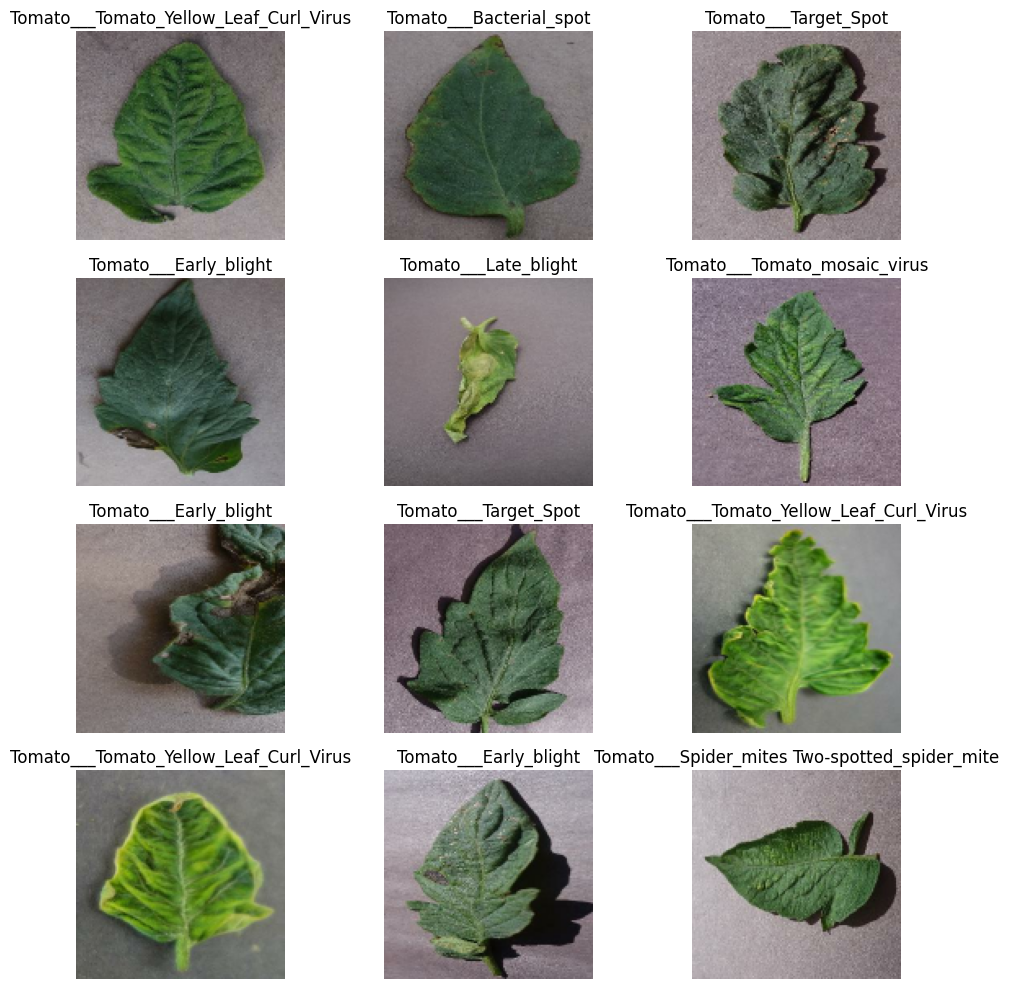

In [39]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10,10))
for image_batch,label_batch in train_data.take(1):
    for i in range(0,12):
        plt.subplot(4,3,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")
plt.tight_layout()
plt.show()

#Data Augmentation

In [40]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal",input_shape=(IMG_SIZE, IMG_SIZE, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.2),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.2)
], name ="data_augmentation")

#Augmented Image View

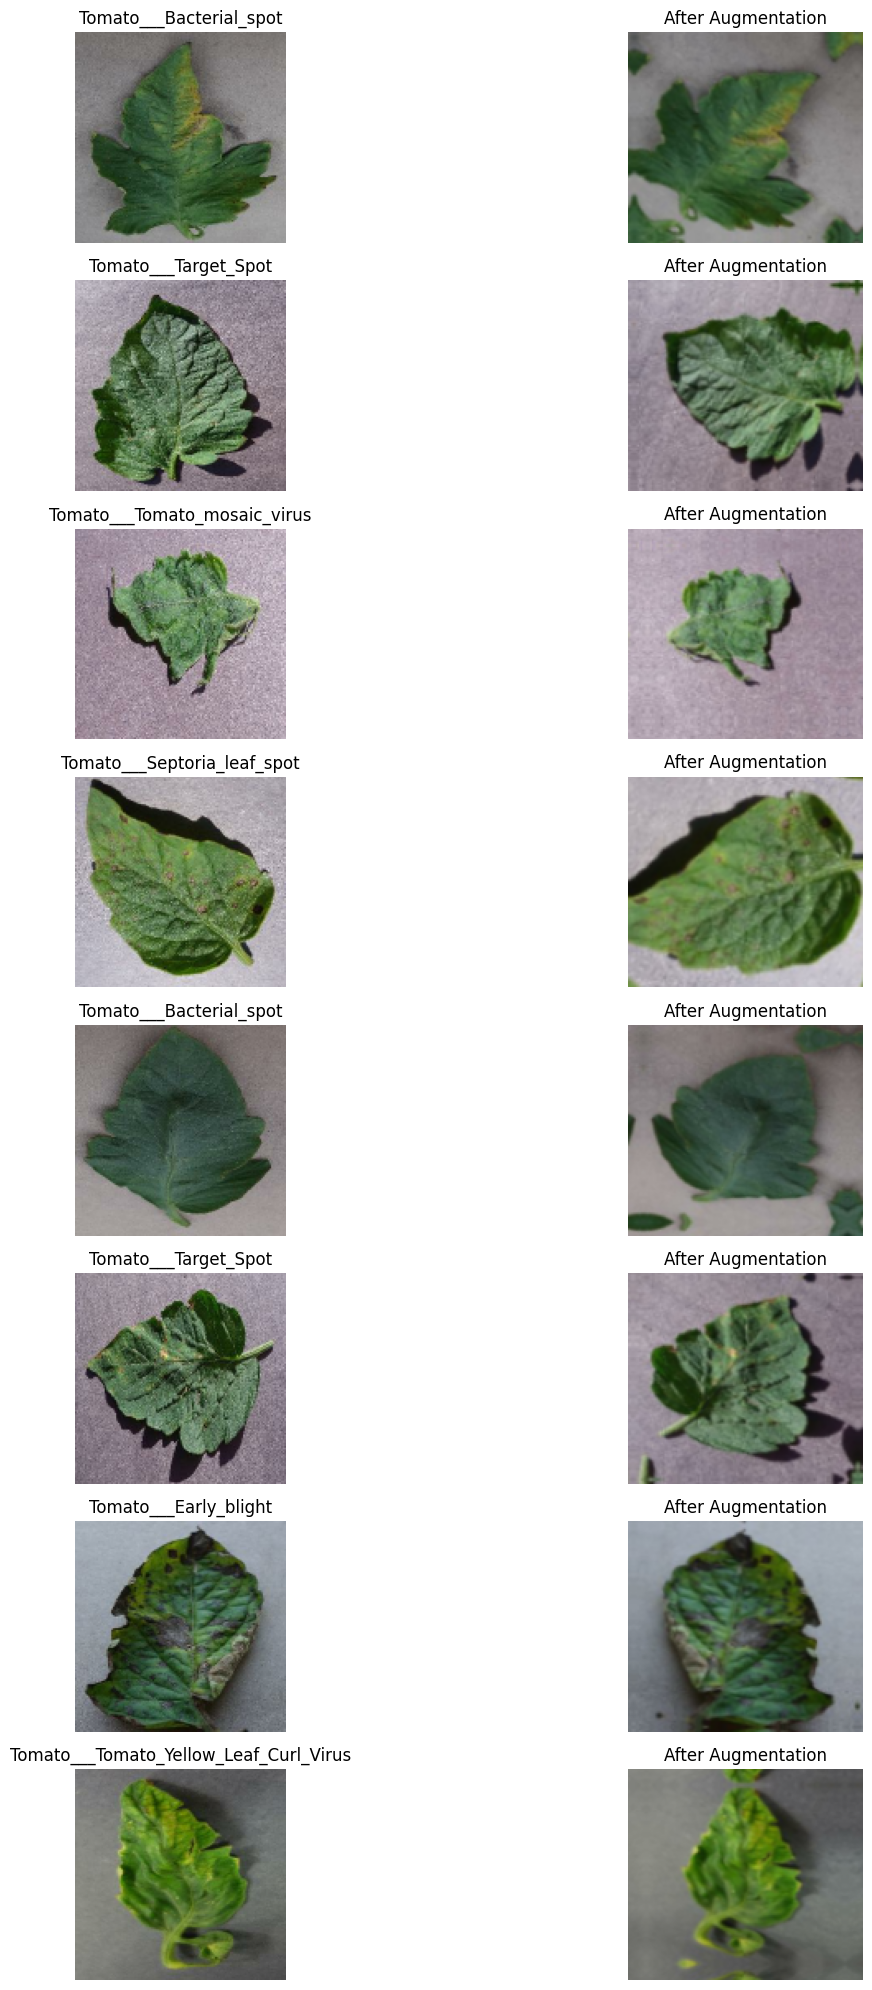

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 20))  # Adjust the figure size as needed

# Assuming train_data is your dataset iterator
for image_batch, label_batch in train_data.take(1):
    augmented_image_batch = data_augmentation(image_batch)
    image_plt_len = min(len(image_batch), 8)  # Ensure we don't exceed 8 images
    for i in range(image_plt_len):
        # Plot original images
        plt.subplot(image_plt_len, 2, 2 * i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint32"))
        plt.title(class_names[np.argmax(label_batch[i])])
        plt.axis("off")

        # Plot augmented images
        plt.subplot(image_plt_len, 2, 2 * i + 2)
        img = augmented_image_batch[i].numpy().astype("uint32")
        plt.imshow(img)
        plt.title("After Augmentation")
        plt.axis("off")

plt.tight_layout()
plt.show()


#Create checkpoint

In [46]:
 checkpoint_path = "/CheckPoint/"
 checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
     checkpoint_path,
     # save_weights_only=True,
     monitor='val_accuracy',
     save_best_only=True
 )


# Model. transferlearning. ResNet50


In [47]:
# ResNet 50 model
import keras

model = keras.Sequential()
resnet = keras.applications.ResNet50(
    include_top=False,
    input_shape=(128, 128, 3),
    pooling='avg',
    classes=len(class_names),
    weights='imagenet'
)

for layer in resnet.layers:
  layer.trainable = False

model.add(resnet)
model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(256, activation= 'relu'))
# model.add(keras.layers.Dropout(rate= 0.2))
# model.add(keras.layers.Dense(128, activation= 'relu'))
# model.add(keras.layers.Dropout(rate= 0.2))
# model.add(keras.layers.Dense(128, activation= 'relu'))
# model.add(keras.layers.Dropout(rate= 0.2))
# model.add(keras.layers.Dense(64, activation= 'relu'))
model.add(keras.layers.Dense(64, activation= 'relu'))
model.add(keras.layers.Dense(len(class_names), activation='softmax', name='output_layer'))


In [48]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 64)                131136    
                                                                 
 output_layer (Dense)        (None, 10)                650       
                                                                 
Total params: 23719498 (90.48 MB)
Trainable params: 131786 (514.79 KB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


#Model Ploting

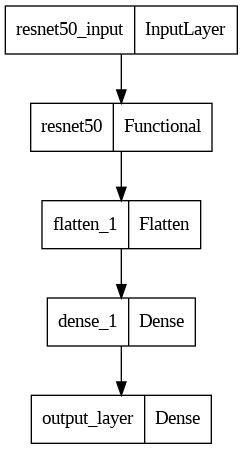

In [49]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=False,        # Set to True to display shapes of the layers
    show_dtype=False,        # Set to True to display data types of the layers
    show_layer_names=True,   # Set to True to display layer names
    rankdir='TB',            # TB for top-bottom direction, LR for left-right direction
    expand_nested=False,     # Set to True to expand nested models
    dpi=96,                  # Dots per inch for the figure resolution
    layer_range=None,        # Range of layers to display
    show_layer_activations=False,  # Set to True to display layer activations
    show_trainable=False     # Set to True to display trainable parameter count
)

#Model Compile

In [50]:
model.compile(
    loss = 'categorical_crossentropy',
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy'],
)

#Model Train

In [51]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=2)
]
history = model.fit(
    train_data,
    epochs=32,
    validation_data = test_data,
    validation_steps = len(test_data),
    # callbacks = callbacks
)

Epoch 1/32
25/25 [==============================] - 69s 3s/step - loss: 1.8427 - accuracy: 0.3825 - val_loss: 1.2179 - val_accuracy: 0.6100
Epoch 2/32
25/25 [==============================] - 61s 2s/step - loss: 0.7805 - accuracy: 0.7575 - val_loss: 0.8534 - val_accuracy: 0.7550
Epoch 3/32
25/25 [==============================] - 69s 3s/step - loss: 0.4903 - accuracy: 0.8750 - val_loss: 0.6954 - val_accuracy: 0.7900
Epoch 4/32
25/25 [==============================] - 69s 3s/step - loss: 0.3224 - accuracy: 0.9287 - val_loss: 0.5834 - val_accuracy: 0.8450
Epoch 5/32
25/25 [==============================] - 70s 3s/step - loss: 0.2334 - accuracy: 0.9638 - val_loss: 0.5440 - val_accuracy: 0.8450
Epoch 6/32
25/25 [==============================] - 64s 3s/step - loss: 0.1915 - accuracy: 0.9625 - val_loss: 0.5385 - val_accuracy: 0.8400
Epoch 7/32
25/25 [==============================] - 70s 3s/step - loss: 0.1411 - accuracy: 0.9787 - val_loss: 0.5465 - val_accuracy: 0.8350
Epoch 8/32
25/25 [==

# Plot history loss and accuracy

In [52]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


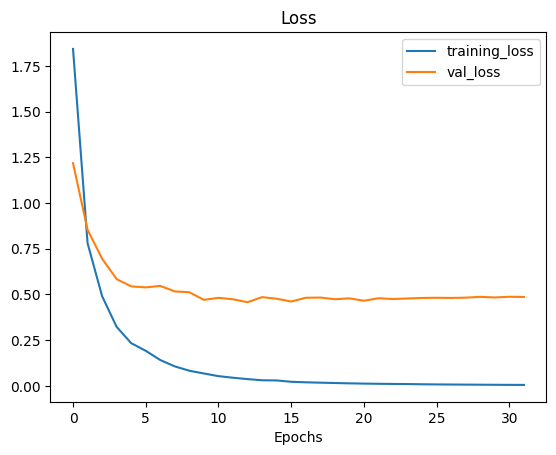

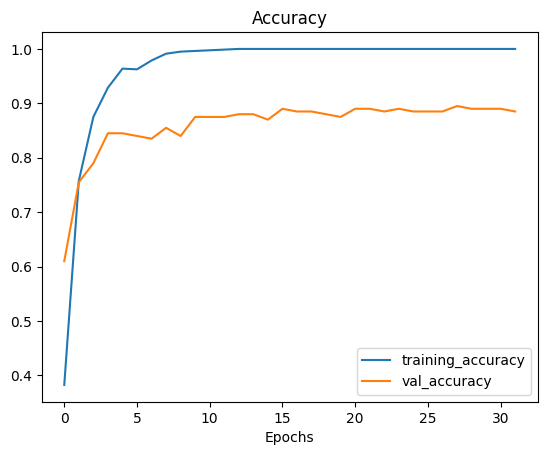

In [53]:
plot_loss_curves(history)

#Evalute model

In [54]:
model.evaluate(test_data)

7/7 [==============================] - 13s 2s/step - loss: 0.4860 - accuracy: 0.8850


[0.4859560430049896, 0.8849999904632568]

#Best Model

In [57]:
"""clone the model"""
# best_model = tf.keras.models.load_model(checkpoint_path)

'clone the model'

#Evalute best model

In [58]:
# best_model.evaluate(test_data)

#Confusion matrix

In [59]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(8, 8), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.tick_params(axis='x', labelrotation=90)
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [60]:
y_true = np.array([])
y_pred = np.array([])
for x, y in test_data:
    y_true = np.concatenate([y_true, np.argmax(y, axis=-1)], axis=0)
    y_pred = np.concatenate([y_pred, np.argmax(model.predict(x), axis=-1)], axis=0)

1/1 [==============================] - 2s 2s/step


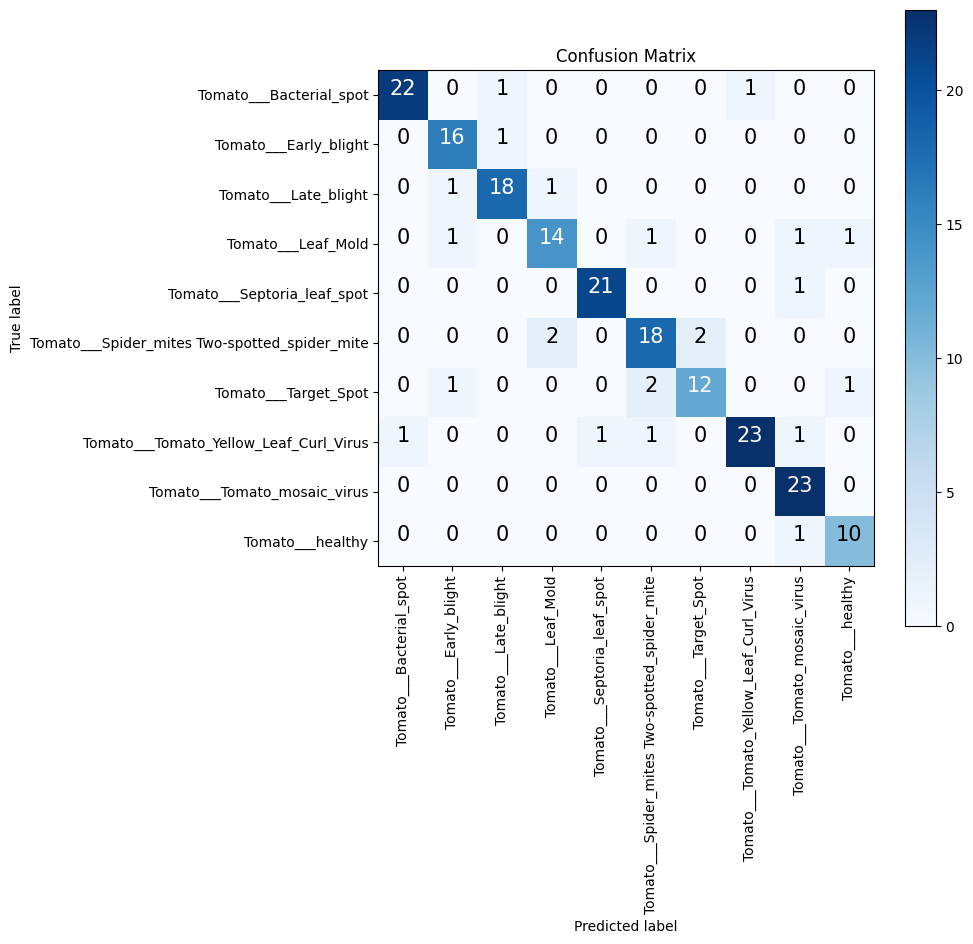

In [61]:
make_confusion_matrix(y_true, y_pred, class_names)

In [62]:
y_pred


array([1., 5., 8., 3., 8., 2., 1., 2., 8., 0., 7., 4., 9., 5., 7., 0., 3.,
       4., 7., 4., 0., 6., 1., 3., 4., 3., 2., 6., 3., 2., 0., 4., 4., 4.,
       4., 0., 7., 0., 7., 4., 1., 0., 1., 7., 5., 8., 8., 2., 6., 7., 0.,
       1., 8., 3., 2., 9., 8., 1., 4., 0., 5., 2., 7., 1., 7., 8., 3., 0.,
       0., 6., 0., 6., 8., 1., 4., 7., 2., 7., 2., 4., 9., 5., 4., 1., 0.,
       9., 5., 3., 8., 8., 0., 0., 6., 8., 2., 5., 0., 3., 1., 2., 8., 0.,
       2., 8., 5., 1., 3., 2., 6., 3., 1., 0., 5., 4., 4., 0., 9., 6., 3.,
       6., 8., 4., 5., 1., 0., 5., 7., 8., 4., 2., 7., 5., 1., 3., 8., 7.,
       3., 8., 7., 4., 9., 7., 5., 1., 9., 5., 3., 9., 7., 3., 7., 5., 8.,
       6., 9., 0., 7., 2., 8., 4., 8., 5., 5., 5., 7., 9., 4., 2., 0., 7.,
       9., 8., 6., 0., 6., 1., 4., 5., 7., 1., 3., 8., 2., 7., 1., 8., 4.,
       6., 2., 7., 2., 8., 2., 6., 5., 5., 8., 5., 9., 8.])

#True-Predicted Data

1/1 [==============================] - 0s 169ms/step


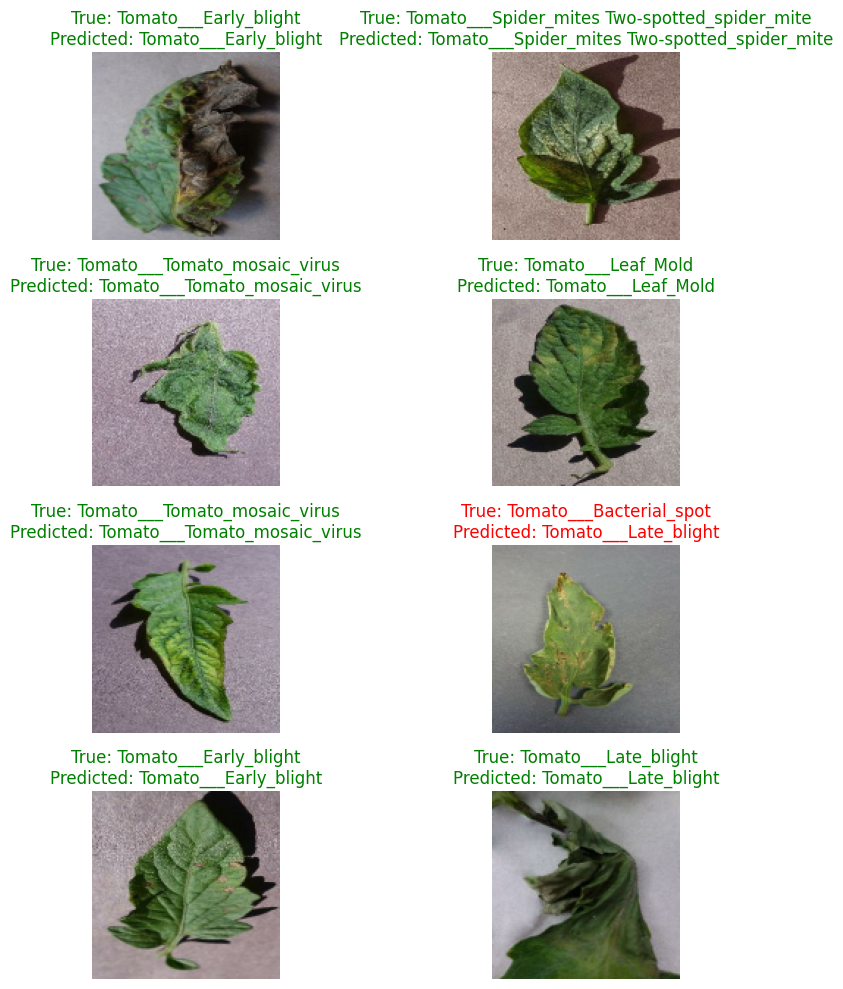

In [67]:
import matplotlib.pyplot as plt

# Initialize counters for correct and incorrect predictions
correct_count = 0
incorrect_count = 0

plt.figure(figsize=(10, 10))
for image_batch, label_batch in test_data.take(1):
    for i in range(8):  # Show 8 images
        plt.subplot(4, 2, i + 1)
        img = image_batch[i].numpy().astype("uint8")
        plt.imshow(img)
        true_class = class_names[np.argmax(label_batch[i])]

        # Expand the image dimensions and make a prediction
        img = np.expand_dims(img, axis=0)
        predict_class = model.predict(img)[0]
        predict_class = class_names[np.argmax(predict_class)]

        title = f"True: {true_class}\nPredicted: {predict_class}"
        if true_class == predict_class:
            plt.title(title, color='g')  # Correct prediction shown in green
            correct_count += 1
        else:
            plt.title(title, color='r')  # Incorrect prediction shown in red
            incorrect_count += 1
        plt.axis("off")

plt.tight_layout()
plt.show()